# Environment Setup

In [1]:
def install_packages():
    """
    Install or upgrade the following packages using pip:
    - pip: Package manager for Python.
    - numpy: Library for numerical computing.
    - pandas: Library for data manipulation and analysis.
    - tensorflow: Framework for machine learning and deep learning.
    - scikit-learn: Library for machine learning algorithms.
    - matplotlib: Library for data visualization.
    - seaborn: Library for statistical data visualization.
    - plotly: Library for interactive plotting and visualization.

    Example:
    >>> install_packages()
    """

    %pip install --upgrade pip
    %pip install numpy
    %pip install pandas
    %pip install tensorflow
    %pip install -U scikit-learn
    %pip install -U matplotlib
    %pip install seaborn
    %pip install plotly

    pass

#install_packages()

In [1]:
# Libraries for data manipulation and analysis
import numpy as np
import pandas as pd
import keras_tuner as kt

# Libraries for Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Reshape
from tensorflow.keras import layers, regularizers, losses, optimizers, models
import numpy as np


# Libraries for machine learning
from sklearn.model_selection import train_test_split  # Splitting data into training and testing sets
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Evaluation metrics for regression models

# Libraries for data visualization
import seaborn as sns

# Data Inspection

In [2]:
# Import data
df = pd.read_csv('selected_coastal.csv')

# Drop rows with missing values from the DataFrame
df = df.dropna()
df.head()

,ID,Storm,Lat,Lon,DistancetoCoast,NumberofHouses,TotalValue_2023,Stories_sum,Stories_median,Elevation,Rainfall_Max,Rainfall_Mean,MaxWind,FloodDepth,Damage,DamageRate
6,20,Henri,40.670,-73.985,0.514557,529,1.223136e+09,1552,3.0,15.217467,19.372613,1.459649,30.238714,0.036165,339.0,2.770000e-07
79,632,Henri,40.591,-73.986,0.647500,406,4.500709e+08,877,2.0,2.572017,19.337048,1.743235,21.807135,0.676823,6961.0,1.550000e-05
101,774,Henri,40.642,-73.886,0.121984,700,3.238386e+08,1171,1.0,2.346287,19.856623,1.791890,37.053437,0.222726,1501.0,4.640000e-06
111,829,Henri,40.578,-73.964,0.502252,633,4.358320e+08,2538,2.0,2.536751,19.789047,1.826365,22.210991,0.201621,5899.0,1.350000e-05
125,880,Henri,40.530,-74.176,0.772571,2160,2.186988e+09,2788,2.0,14.402827,19.446697,1.582410,9.769062,0.161686,9309.0,4.260000e-06


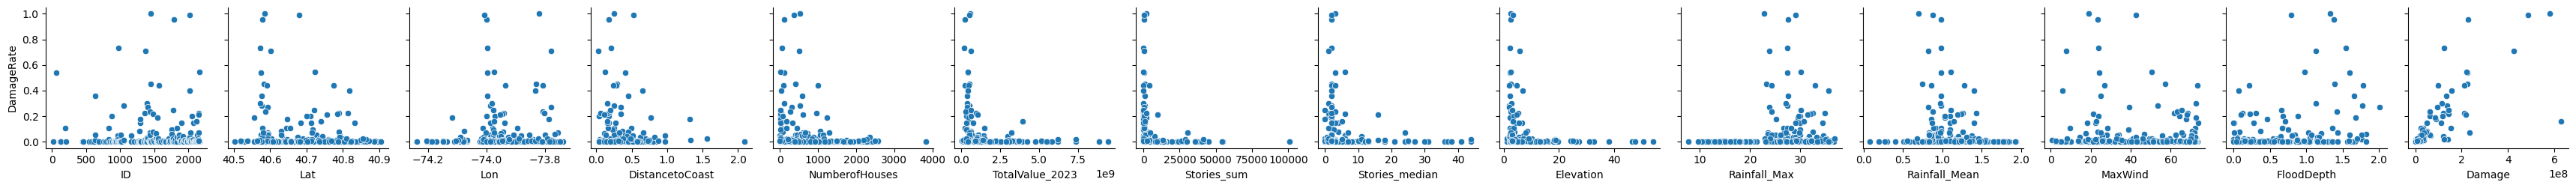

In [4]:
# Create a pairwise scatter plot matrix
sns.pairplot(
    df,
    x_vars=df.drop(columns=['Storm','DamageRate']).columns,
    y_vars=["DamageRate"]
)

## Observations
1. Our data is structured (a csv)
2. The goal is a regression: predicting FloodDepth (continuous variable)
3. FloodDepth has a non-linear relationship with the other features

# Neural Network

## Version 1 (Conv1D NN)

In [3]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

# Assuming df and other necessary imports are defined

# Data preprocessing
X = df["FloodDepth"].values.reshape(-1, 1, 1)
y = df['DamageRate']

# Data normalization
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X.reshape(-1, 1)).reshape(-1, 1, 1)

# Splitting the normalized data
x_train_norm, x_test_norm, y_train_norm, y_test_norm = train_test_split(X_normalized, y, test_size=0.2, random_state=85)

# Splitting the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=85)

# Normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(x_train))

# Function to build a more complex model
def build_complex_model(hp):
    model = keras.Sequential()

    # Convolutional Layers
    model.add(layers.Conv1D(filters=hp.Int('conv1_filters', min_value=32, max_value=256, step=32),
                             kernel_size=hp.Int('conv1_kernel', min_value=3, max_value=7, step=2),
                             activation='relu', padding='same',
                             kernel_regularizer=keras.regularizers.l2(hp.Float('conv1_reg', min_value=1e-5, max_value=1e-2, sampling='log'))))
    model.add(layers.MaxPooling1D(pool_size=2, padding='same'))

    model.add(layers.Conv1D(filters=hp.Int('conv2_filters', min_value=64, max_value=512, step=64),
                             kernel_size=hp.Int('conv2_kernel', min_value=3, max_value=7, step=2),
                             activation='relu', padding='same',
                             kernel_regularizer=keras.regularizers.l2(hp.Float('conv2_reg', min_value=1e-5, max_value=1e-2, sampling='log'))))
    model.add(layers.MaxPooling1D(pool_size=2, padding='same'))

    model.add(layers.Conv1D(filters=hp.Int('conv3_filters', min_value=64, max_value=512, step=64),
                             kernel_size=hp.Int('conv3_kernel', min_value=3, max_value=7, step=2),
                             activation='relu', padding='same',
                             kernel_regularizer=keras.regularizers.l2(hp.Float('conv3_reg', min_value=1e-5, max_value=1e-2, sampling='log'))))
    model.add(layers.GlobalAveragePooling1D())

    # Dense layers
    model.add(layers.Dense(units=hp.Int('dense_units', min_value=64, max_value=512, step=64), activation='relu',
                            kernel_regularizer=keras.regularizers.l2(hp.Float('dense_reg', min_value=1e-5, max_value=1e-2, sampling='log'))))
    model.add(layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer
    model.add(layers.Dense(1, activation='linear'))

    # Compile model
    model.compile(optimizer='adam', loss='Huber', metrics=['mae'])

    return model

# Define tuner
tuner = RandomSearch(
    build_complex_model,
    objective='val_loss',
    max_trials=10,  # Increased number of trials
    executions_per_trial=2,  # Adjusted executions per trial
    directory='keras_tuner_dir',
    project_name='flood_damage_rate'
)

# Perform hyperparameter search
tuner.search(x_train, y_train, epochs=30, validation_data=(x_test, y_test), batch_size=32)

# Get best model
best_model = tuner.get_best_models(num_models=1)[0]

# Summary of the best model
best_model.summary()

# Train the best model
history = best_model.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_test, y_test))


/var/folders/67/9bhls37x5n73swp1vpcp_0280000gn/T/ipykernel_29740/1158390886.py:7: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Reloading Tuner from keras_tuner_dir/flood_damage_rate/tuner0.json


/Users/xanderyoon/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 160)         │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 160)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 384)         │       184,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 384)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1, 64)          │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 192)            │        12,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 272,129 (1.04 MB)

 Trainable params: 272,129 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0130 - mae: 0.0550 - val_loss: 0.0054 - val_mae: 0.0377
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0109 - mae: 0.0621 - val_loss: 0.0041 - val_mae: 0.0240
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0139 - mae: 0.0607 - val_loss: 0.0034 - val_mae: 0.0246
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - mae: 0.0489 - val_loss: 0.0033 - val_mae: 0.0323
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0126 - mae: 0.0712 - val_loss: 0.0032 - val_mae: 0.0346
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0136 - mae: 0.0754 - val_loss: 0.0022 - val_mae: 0.0225
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095 - mae: 0.0498 - val_loss: 0.0019 - val_mae: 0.0181
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0122 - mae: 0.0523 - val_loss: 0.0017 - val_mae: 0.0309
Epoch 9/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0098 - mae: 0.0576 - val_loss

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
R^2 score: 0.326


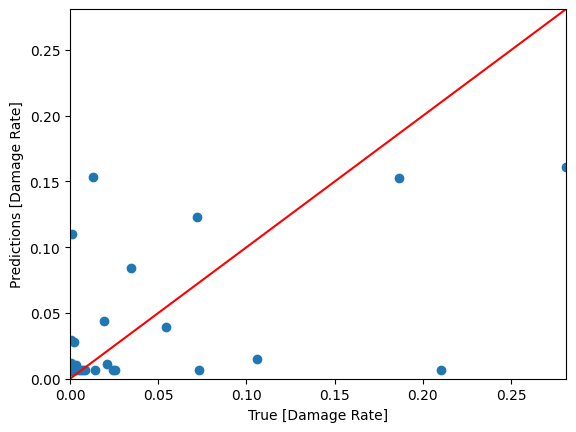

In [4]:
test_predictions = best_model.predict(x_test).flatten()

# Calculate R^2
r2 = r2_score(y_test, test_predictions)
print(f"R^2 score: {r2:.3f}")

import model_utils as util
util.plot_predict(test_predictions, y_test)

## Version 2 (Polynomial Regression)

In [7]:
# Extract the 'DamageRate' and reshape it to a 2D array
X = df["FloodDepth"].values.reshape(-1, 1)  

# Target/Dependent variable
y = df['DamageRate']

# Splitting the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=85)

In [8]:
"""from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

best_degree = 0
best_r2 = -1

for degree in range(20, 50):
    poly_reg = PolynomialFeatures(degree=degree)
    X_poly = poly_reg.fit_transform(X)
    lin_reg = LinearRegression()
    lin_reg.fit(X_poly, y)
    y_pred = lin_reg.predict(X_poly)
    r2 = r2_score(y, y_pred)
    
    if r2 > best_r2:
        best_r2 = r2
        best_degree = degree

print("Best degree:", best_degree)
print("Best R^2 score:", best_r2) Best: 41"""

'from sklearn.metrics import r2_score\nfrom sklearn.preprocessing import PolynomialFeatures\nfrom sklearn.linear_model import LinearRegression\n\nbest_degree = 0\nbest_r2 = -1\n\nfor degree in range(20, 50):\n    poly_reg = PolynomialFeatures(degree=degree)\n    X_poly = poly_reg.fit_transform(X)\n    lin_reg = LinearRegression()\n    lin_reg.fit(X_poly, y)\n    y_pred = lin_reg.predict(X_poly)\n    r2 = r2_score(y, y_pred)\n    \n    if r2 > best_r2:\n        best_r2 = r2\n        best_degree = degree\n\nprint("Best degree:", best_degree)\nprint("Best R^2 score:", best_r2) Best: 41'